In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load Data 
agreement_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_feature_agreement_summary.csv")
temporal_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_temporal_shape_patterns_annotated.csv")


In [4]:
#Merge on gene_name
merged_df = pd.merge(agreement_df, temporal_df, on="gene_name")


In [5]:
#  Create Crosstab 
crosstab = pd.crosstab(merged_df["combined_pattern"], merged_df["agreement_class"])

#Display Crosstab Table
print("\n=== Temporal Shape Pattern vs Feature Agreement Encoding ===")
crosstab




=== Temporal Shape Pattern vs Feature Agreement Encoding ===


agreement_class,accessibility_only,conflict,expr_acc_down,expr_acc_up,expression_only,mixed,stable
combined_pattern,,,,,,,
brief dip & brief spike,3,5,0,0,2,9,1
flat & gradual down,241,87,15,7,51,227,79
noise,16,13,1,1,5,36,3


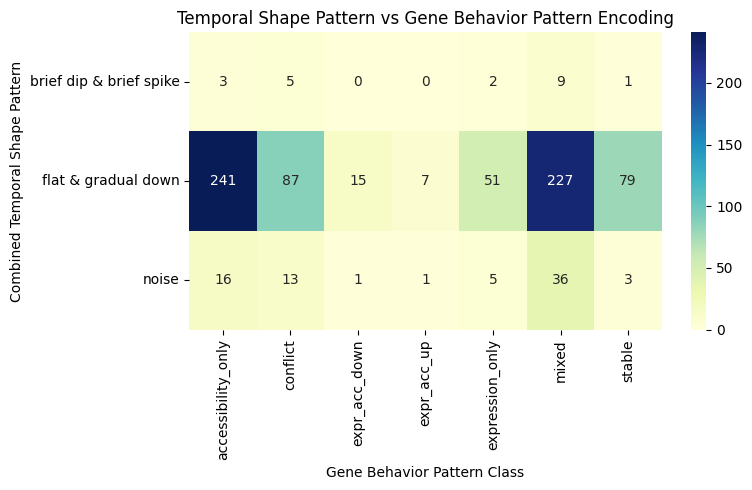

In [16]:
# Plot Heatmap 
plt.figure(figsize=(8, 5))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Temporal Shape Pattern vs Gene Behavior Pattern Encoding")
plt.xlabel("Gene Behavior Pattern Class")
plt.ylabel("Combined Temporal Shape Pattern")
plt.tight_layout()
plt.show()

In [7]:
# Most frequent temporal patterns
print(merged_df["combined_pattern"].value_counts().head(10))

# Most frequent agreement classes within a specific temporal pattern
merged_df[merged_df["combined_pattern"] == "gradual up & gradual up"]["agreement_class"].value_counts()


combined_pattern
flat & gradual down        707
noise                       75
brief dip & brief spike     20
Name: count, dtype: int64


Series([], Name: count, dtype: int64)

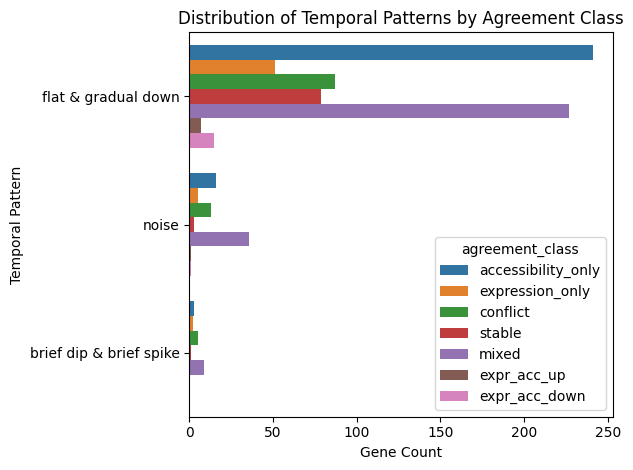

In [8]:
sns.countplot(data=merged_df, y="combined_pattern", hue="agreement_class", order=merged_df["combined_pattern"].value_counts().index)
plt.title("Distribution of Temporal Patterns by Agreement Class")
plt.xlabel("Gene Count")
plt.ylabel("Temporal Pattern")
plt.tight_layout()
plt.show()


In [9]:
merged_df["combined_label"] = merged_df["combined_pattern"] + " | " + merged_df["agreement_class"]
label_counts = merged_df["combined_label"].value_counts()
print(label_counts.head(10))


combined_label
flat & gradual down | accessibility_only    241
flat & gradual down | mixed                 227
flat & gradual down | conflict               87
flat & gradual down | stable                 79
flat & gradual down | expression_only        51
noise | mixed                                36
noise | accessibility_only                   16
flat & gradual down | expr_acc_down          15
noise | conflict                             13
brief dip & brief spike | mixed               9
Name: count, dtype: int64


- The most common gene response pattern is a flat expression profile combined with gradually decreasing accessibility, indicating that many genes undergo chromatin closing without corresponding gene expression changes.

- A large number of genes fall into the “accessibility_only” and “mixed” agreement classes, suggesting that accessibility changes are often not accompanied by consistent expression shifts.

- Coordinated up or down regulation of both expression and accessibility is rare, implying that linear gene activation or silencing is not the dominant for chr 1.

- Many genes exhibit conflicting or mixed expression-accessibility directions across timepoints

- The presence of an “expression_only” category, though smaller, highlights cases where gene expression changes occur without detectable chromatin remodeling.

- Overall, the system appears to favor epigenetic silencing through accessibility loss, with expression changes  being regulated independently in many genes.


In [10]:
interesting = merged_df[
    (merged_df["combined_pattern"].str.contains("brief|complex")) &
    (merged_df["agreement_class"] == "conflict")
]
interesting

,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,...,expr_down_acc_up,agreement_class,tsne_1,tsne_2,tsne_expr_1,tsne_expr_2,expression_pattern,accessibility_pattern,combined_pattern,combined_label
134,LOC103222589,0.087513,0.595877,3.288367,7.69873,7.057177,7.41512,6.336552,5.13529,8.986778,...,0,conflict,43.623722,13.527258,43.623722,13.527258,gradual up,gradual down,brief dip & brief spike,brief dip & brief spike | conflict
221,LOC103233298,0.815376,0.049220,2.502847,5.29288,6.392706,3.37051,7.714710,2.71868,5.717864,...,0,conflict,41.372963,10.045959,41.372963,10.045959,gradual up,gradual down,brief dip & brief spike,brief dip & brief spike | conflict
512,LOC103241038,0.030651,0.736788,2.285222,9.62341,9.623410,5.39281,5.392810,10.27060,10.270600,...,0,conflict,39.092342,12.420297,39.092342,12.420297,gradual up,gradual down,brief dip & brief spike,brief dip & brief spike | conflict
516,DCHS1,0.683055,-0.798412,3.404561,2.88702,5.954489,12.80790,7.190407,3.32283,5.190205,...,1,conflict,43.927456,10.887635,43.927456,10.887635,gradual up,gradual down,brief dip & brief spike,brief dip & brief spike | conflict
641,LOC103248252,1.343233,-0.669385,3.404564,6.73639,10.051124,4.04461,12.807927,5.13529,8.911228,...,1,conflict,43.820553,10.135971,43.820553,10.135971,noise,gradual down,brief dip & brief spike,brief dip & brief spike | conflict


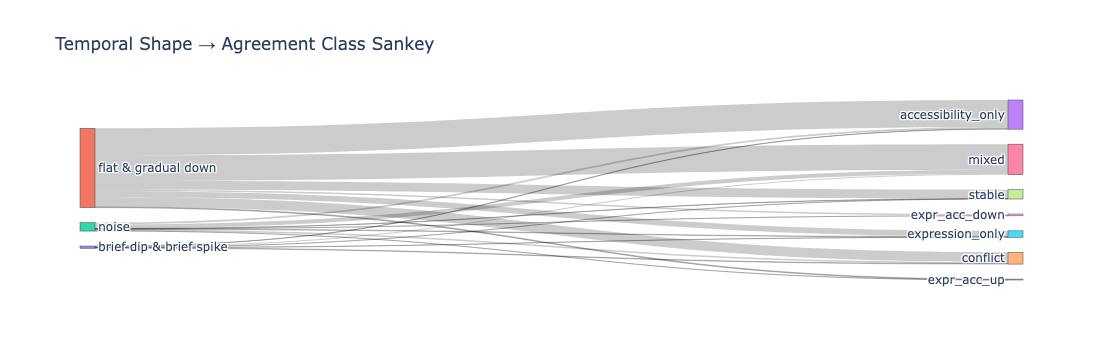

In [11]:
from collections import defaultdict
import plotly.graph_objects as go

# Count transitions
sankey_data = merged_df.groupby(["combined_pattern", "agreement_class"]).size().reset_index(name="count")

# Build node list
all_patterns = sankey_data["combined_pattern"].unique().tolist()
all_classes = sankey_data["agreement_class"].unique().tolist()
nodes = all_patterns + all_classes

# Indices for Sankey
pattern_idx = {k: i for i, k in enumerate(all_patterns)}
class_idx = {k: i + len(all_patterns) for i, k in enumerate(all_classes)}

# Build link data
source = sankey_data["combined_pattern"].map(pattern_idx)
target = sankey_data["agreement_class"].map(class_idx)
value = sankey_data["count"]

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(label=nodes, pad=15, thickness=15),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="Temporal Shape → Agreement Class Sankey", font_size=12)
fig.show()


In [12]:
merged_df.to_csv("data/green_monkey/all_structure_files/chr1/chr1_temporal_trend_shapePattern_classPattern.csv", index=False)